In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
epoch_key = ("Jaq", 3, 12)

In [4]:
from dask.distributed import Client

client = Client(n_workers=32, threads_per_worker=1)
client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44949 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:44875 Dashboard: http://127.0.0.1:44949/status,Cluster Workers: 32 Cores: 32 Memory: 1.62 TB


In [5]:
from src.load_data import load_data

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

16-Dec-20 14:41:28 Loading position info...
16-Dec-20 14:42:03 Loading multiunit...
16-Dec-20 14:42:26 Loading spikes...
16-Dec-20 14:43:51 Finding ripple times...


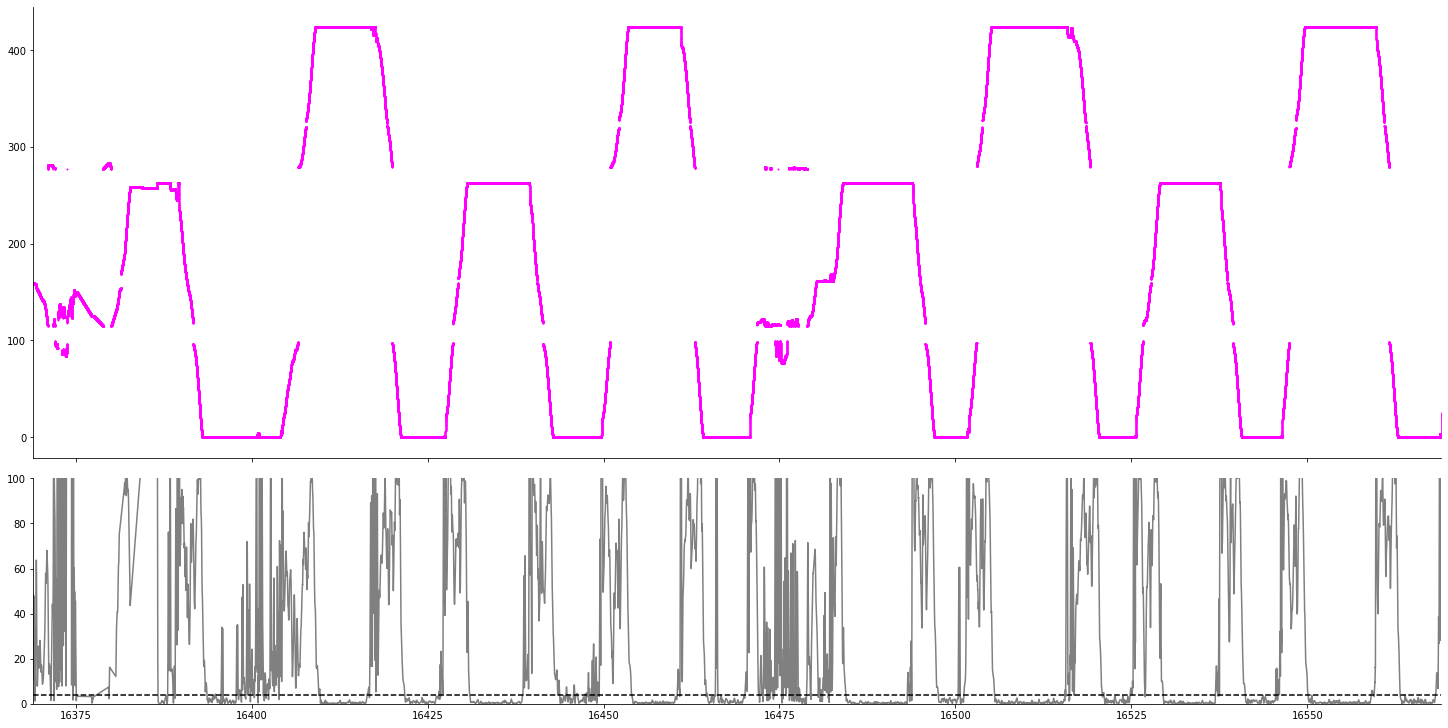

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})
time = data['position_info'].index / np.timedelta64(1, 's')
axes[0].scatter(time, data['position_info'].linear_position.values, color='magenta', s=1)
axes[1].plot(time, data['position_info'].nose_vel.values.squeeze(), color='grey')
axes[1].axhline(4, color='black', linestyle='--')
axes[1].set_ylim((0, 100))

plt.xlim((time.min(), time.min() + 200))
sns.despine()

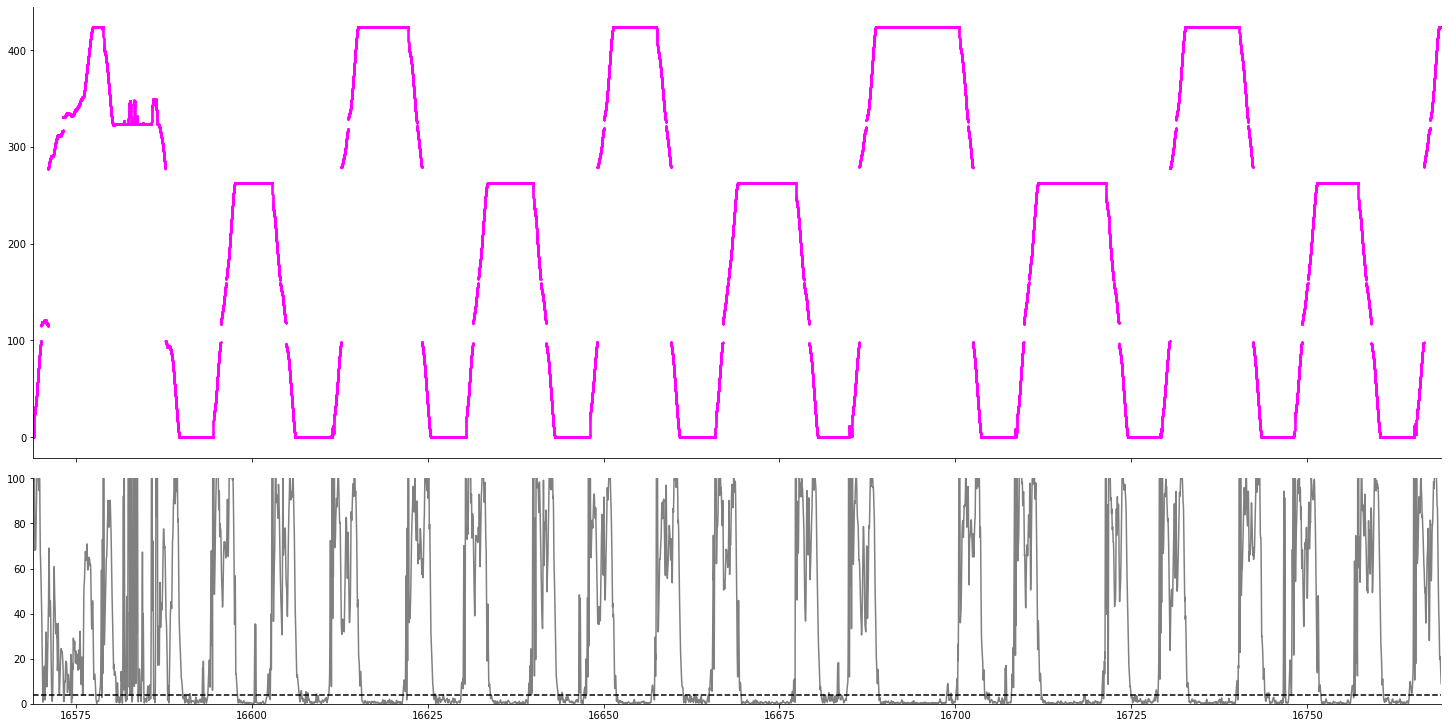

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})
time = data['position_info'].index / np.timedelta64(1, 's')
axes[0].scatter(time, data['position_info'].linear_position.values, color='magenta', s=1)
axes[1].plot(time, data['position_info'].nose_vel.values.squeeze(), color='grey')
axes[1].axhline(4, color='black', linestyle='--')
axes[1].set_ylim((0, 100))

plt.xlim((time.min() + 200, time.min() + 400))
sns.despine()

In [8]:
from replay_identification import ReplayDetector

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'lfp_model_kwargs': {'n_components': 1, 'max_iter': 200, 'tol': 1e-06},
    'spike_model_knot_spacing': 10,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk'
}

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

16-Dec-20 14:44:44 ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mode...
               multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=10,
               spike_

In [9]:
EDGE_ORDER = [0, 1, 3, 2, 4]
EDGE_SPACING = [15, 0, 15, 0]

replay_detector.fit(
    is_ripple=data['is_ripple'],
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    center_well_id=0,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

16-Dec-20 14:44:44 Fitting speed model...
16-Dec-20 14:44:46 Fitting spiking model...


16-Dec-20 14:53:57 Fitting replay movement state transition...


16-Dec-20 14:53:57 Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mode...
               multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=10,
               spike_model_penalty=0.5)

In [10]:
# replay_detector.plot_fitted_place_fields(sampling_frequency=500)

In [11]:
import numpy as np

detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_smoother=True)

detector_results

16-Dec-20 14:54:03 Predicting spikes likelihood...


16-Dec-20 14:55:57 Finding causal replay probability and position...
16-Dec-20 14:56:10 Finding acausal replay probability and position...


<xarray.Dataset>
Dimensions:             (position: 201, state: 2, time: 448257)
Coordinates:
  * time                (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position            (position) float64 0.9993 2.998 4.997 ... 420.7 422.7
  * state               (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 4.113e-09
    likelihood          (time, state, position) float64 1.0 1.0 1.0 ... 1.0 1.0
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 4.113e-09
    replay_probability  (time) float64 0.0 1.335e-32 2.058e-32 ... 0.9995 0.985

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]})
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    max_consensus = np.ceil(data['ripple_consensus_trace'].values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = data['ripple_consensus_trace'].loc[start_time:end_time]
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((0, max_consensus))
    axes[0].set_yticks((0, max_consensus))
    axes[0].set_ylabel("Ripple\nPower")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).replay_probability >= 0.8,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).replay_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

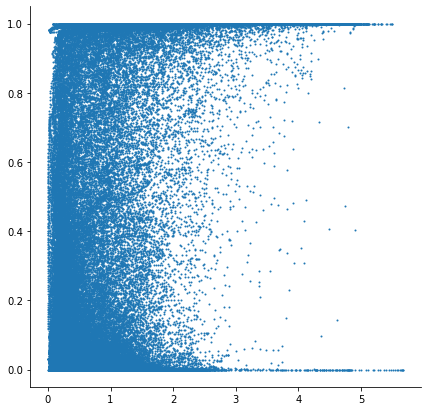

In [13]:
plt.figure(figsize=(7, 7))
plt.scatter(data['multiunit_firing_rate'] / data['multiunit_firing_rate'].mean(), detector_results.replay_probability, s=1)
sns.despine()

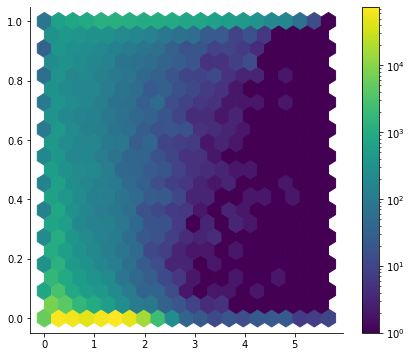

In [14]:
plt.figure(figsize=(7, 6))
plt.hexbin(data['multiunit_firing_rate'].squeeze() / data['multiunit_firing_rate'].values.mean(),
           detector_results.replay_probability.squeeze(),
           gridsize=20, bins='log')
plt.colorbar()
sns.despine()

In [15]:
data.keys()

dict_keys(['position_info', 'tetrode_info', 'neuron_info', 'spikes', 'track_graph', 'ripple_times', 'ripple_labels', 'ripple_filtered_lfps', 'ripple_consensus_trace', 'ripple_lfps', 'ripple_consensus_trace_zscore', 'instantaneous_ripple_power_change', 'is_ripple', 'multiunits', 'multiunit_spikes', 'multiunit_firing_rate', 'multiunit_high_synchrony_times', 'multiunit_high_synchrony_labels', 'multiunit_rate_change', 'multiunit_rate_zscore', 'is_multiunit_high_synchrony'])

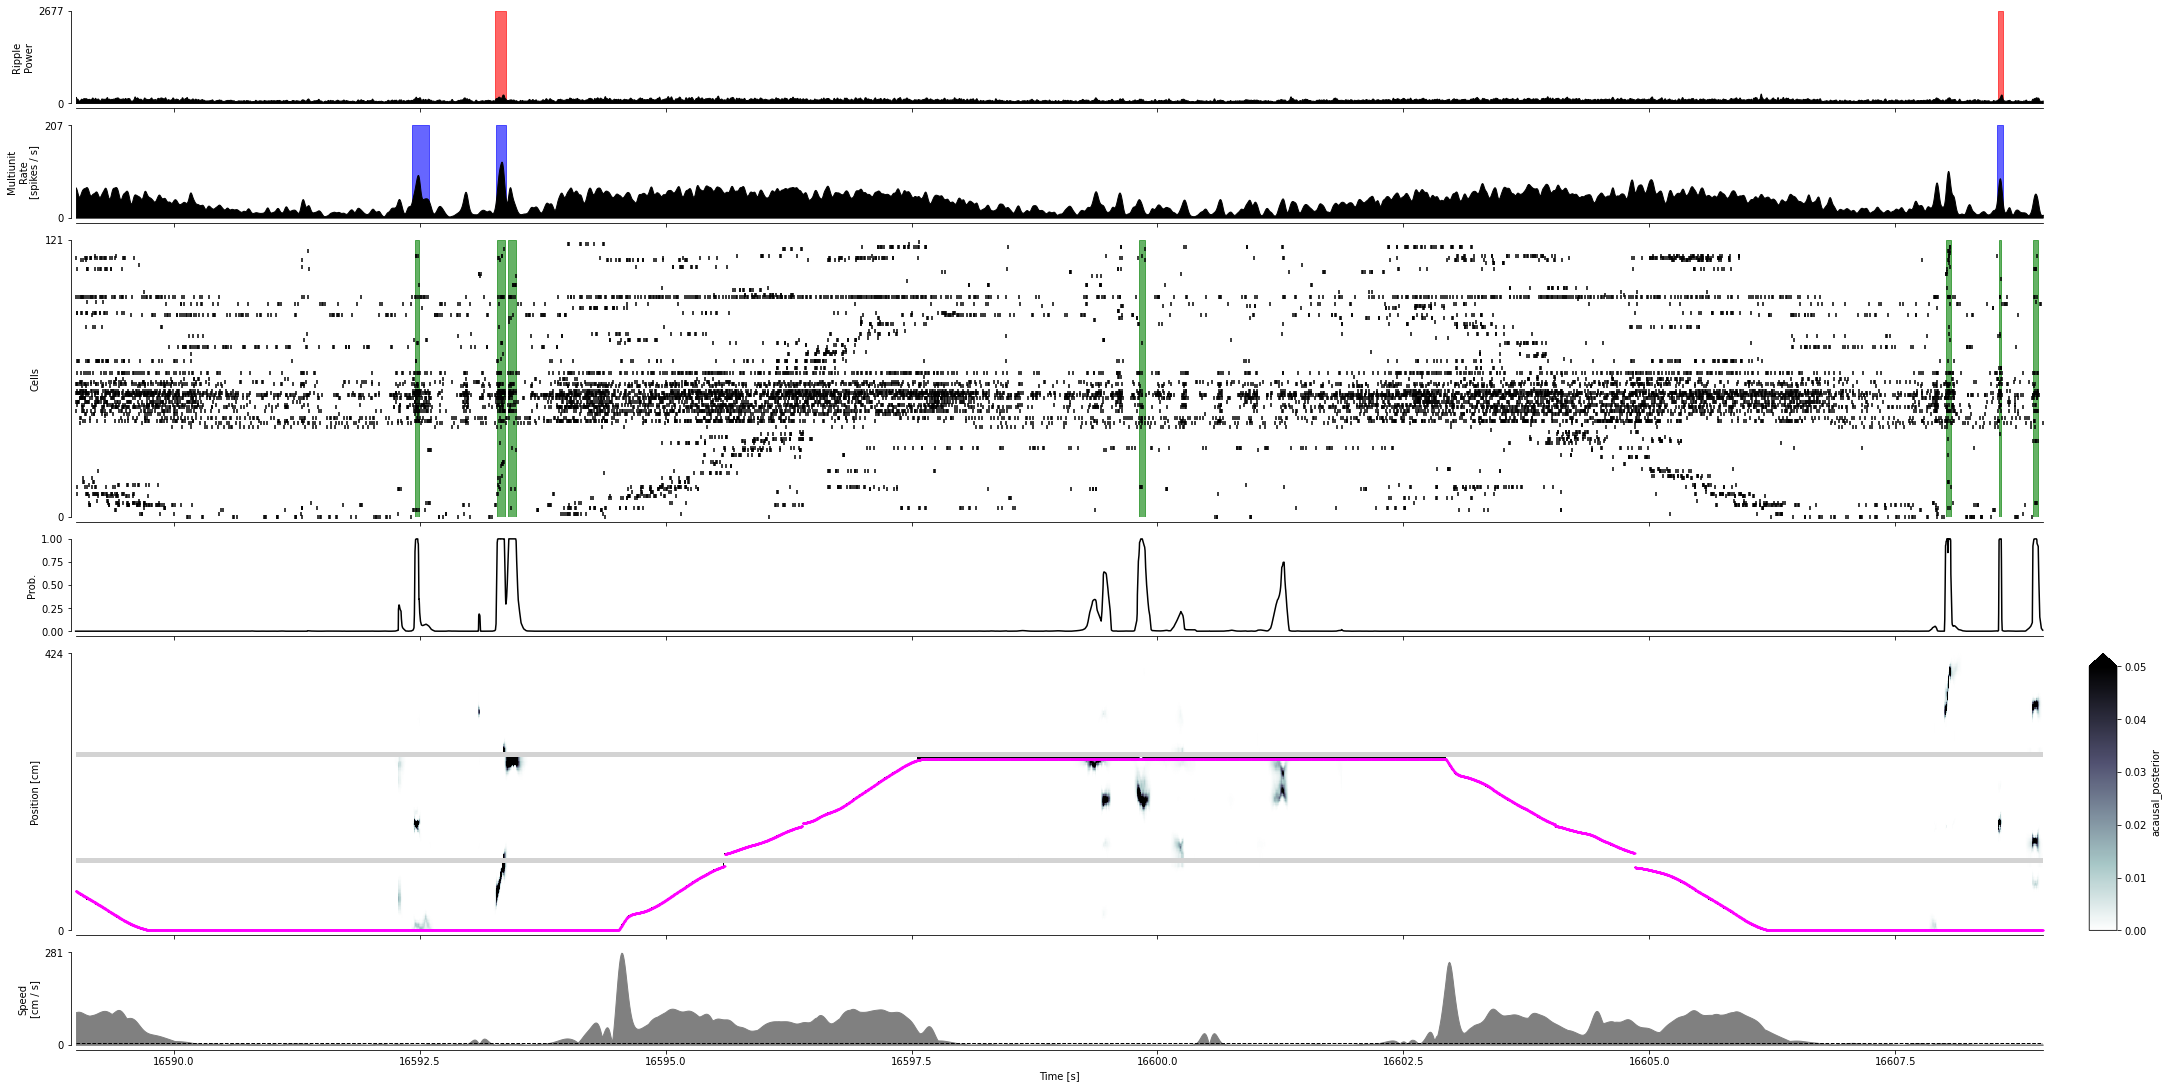

In [16]:
time_ind = slice(110_000, 120_000)

plot_detector(time_ind, data, replay_detector, detector_results, figsize=(30, 15))

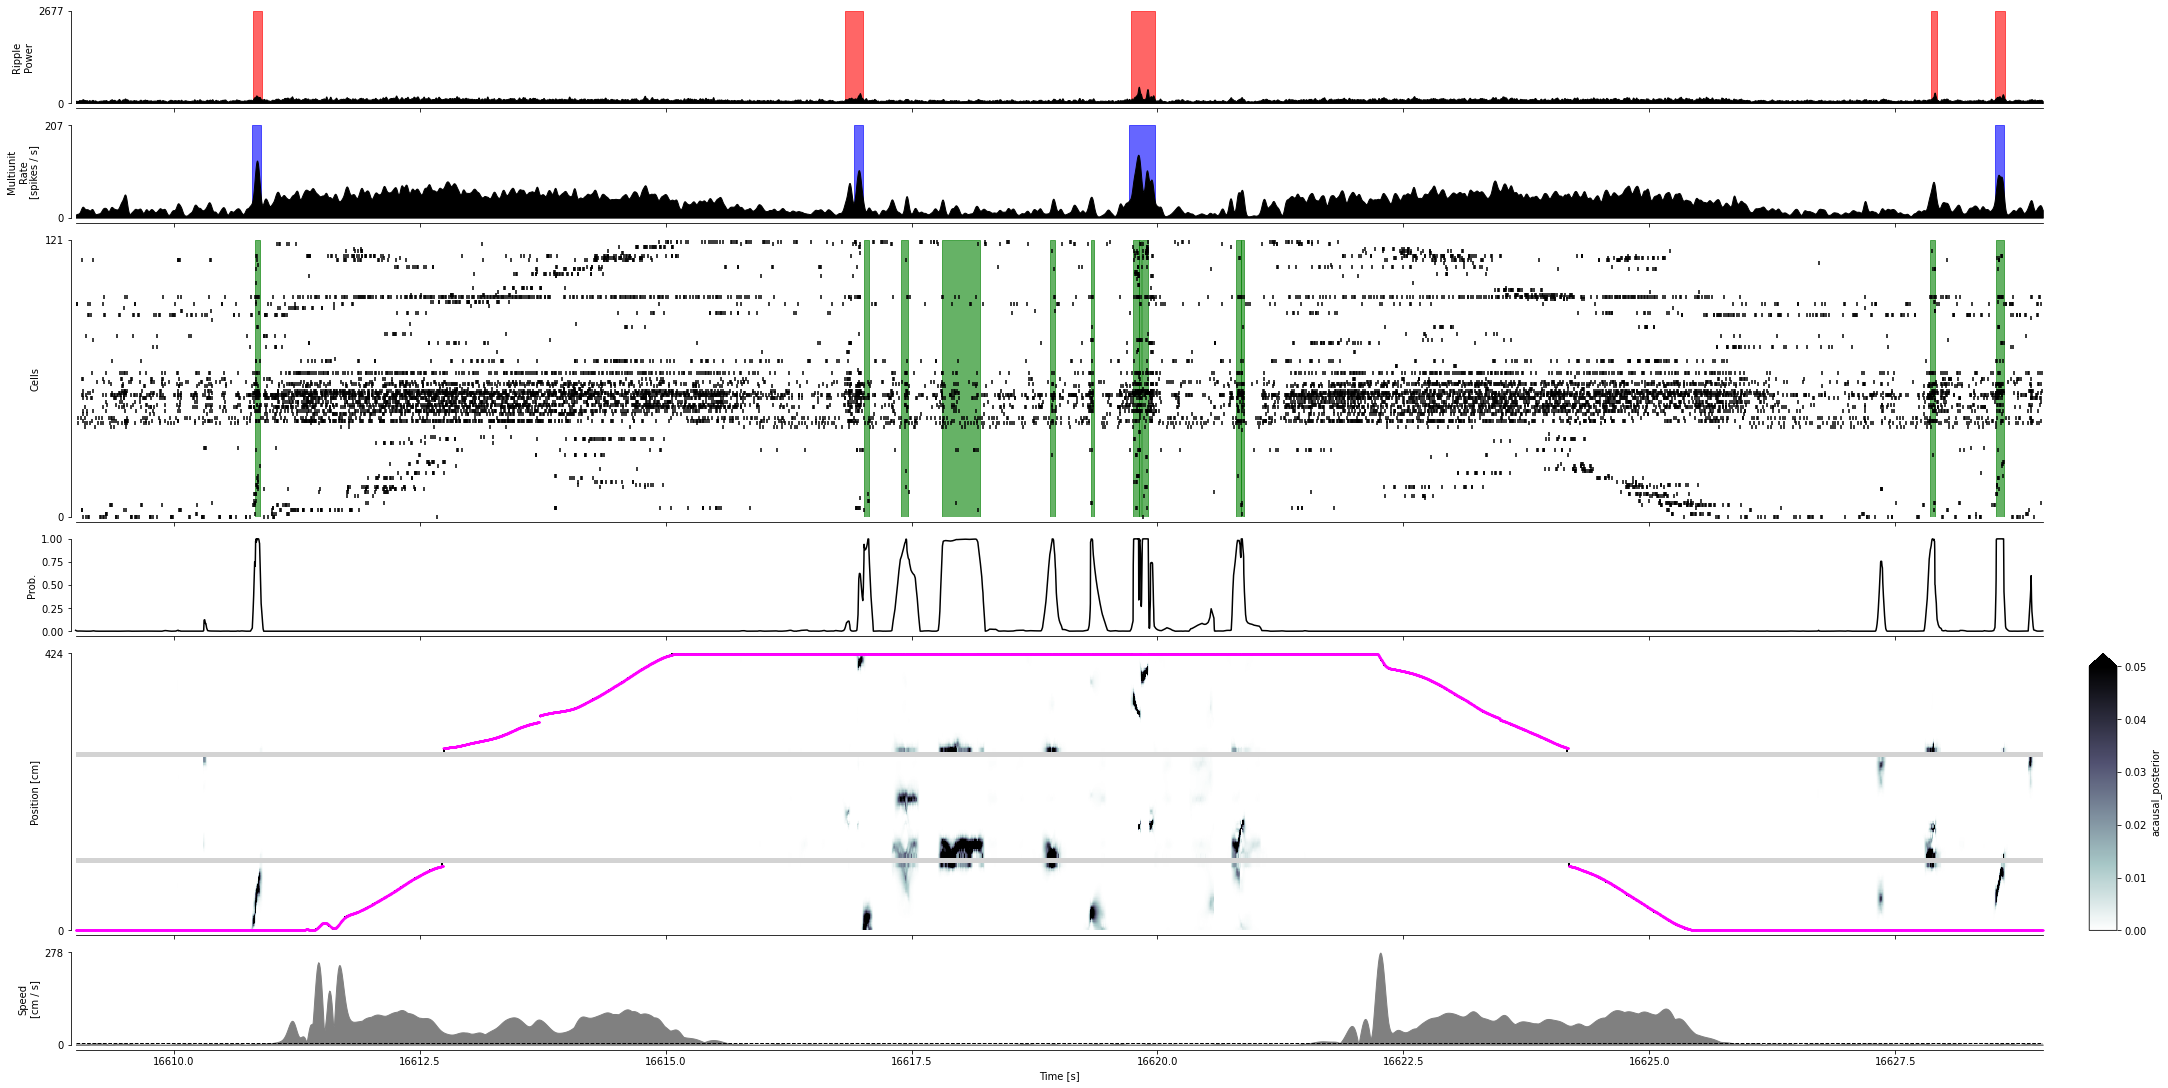

In [17]:
time_ind = slice(120_000, 130_000)

plot_detector(time_ind, data, replay_detector, detector_results, figsize=(30, 15))

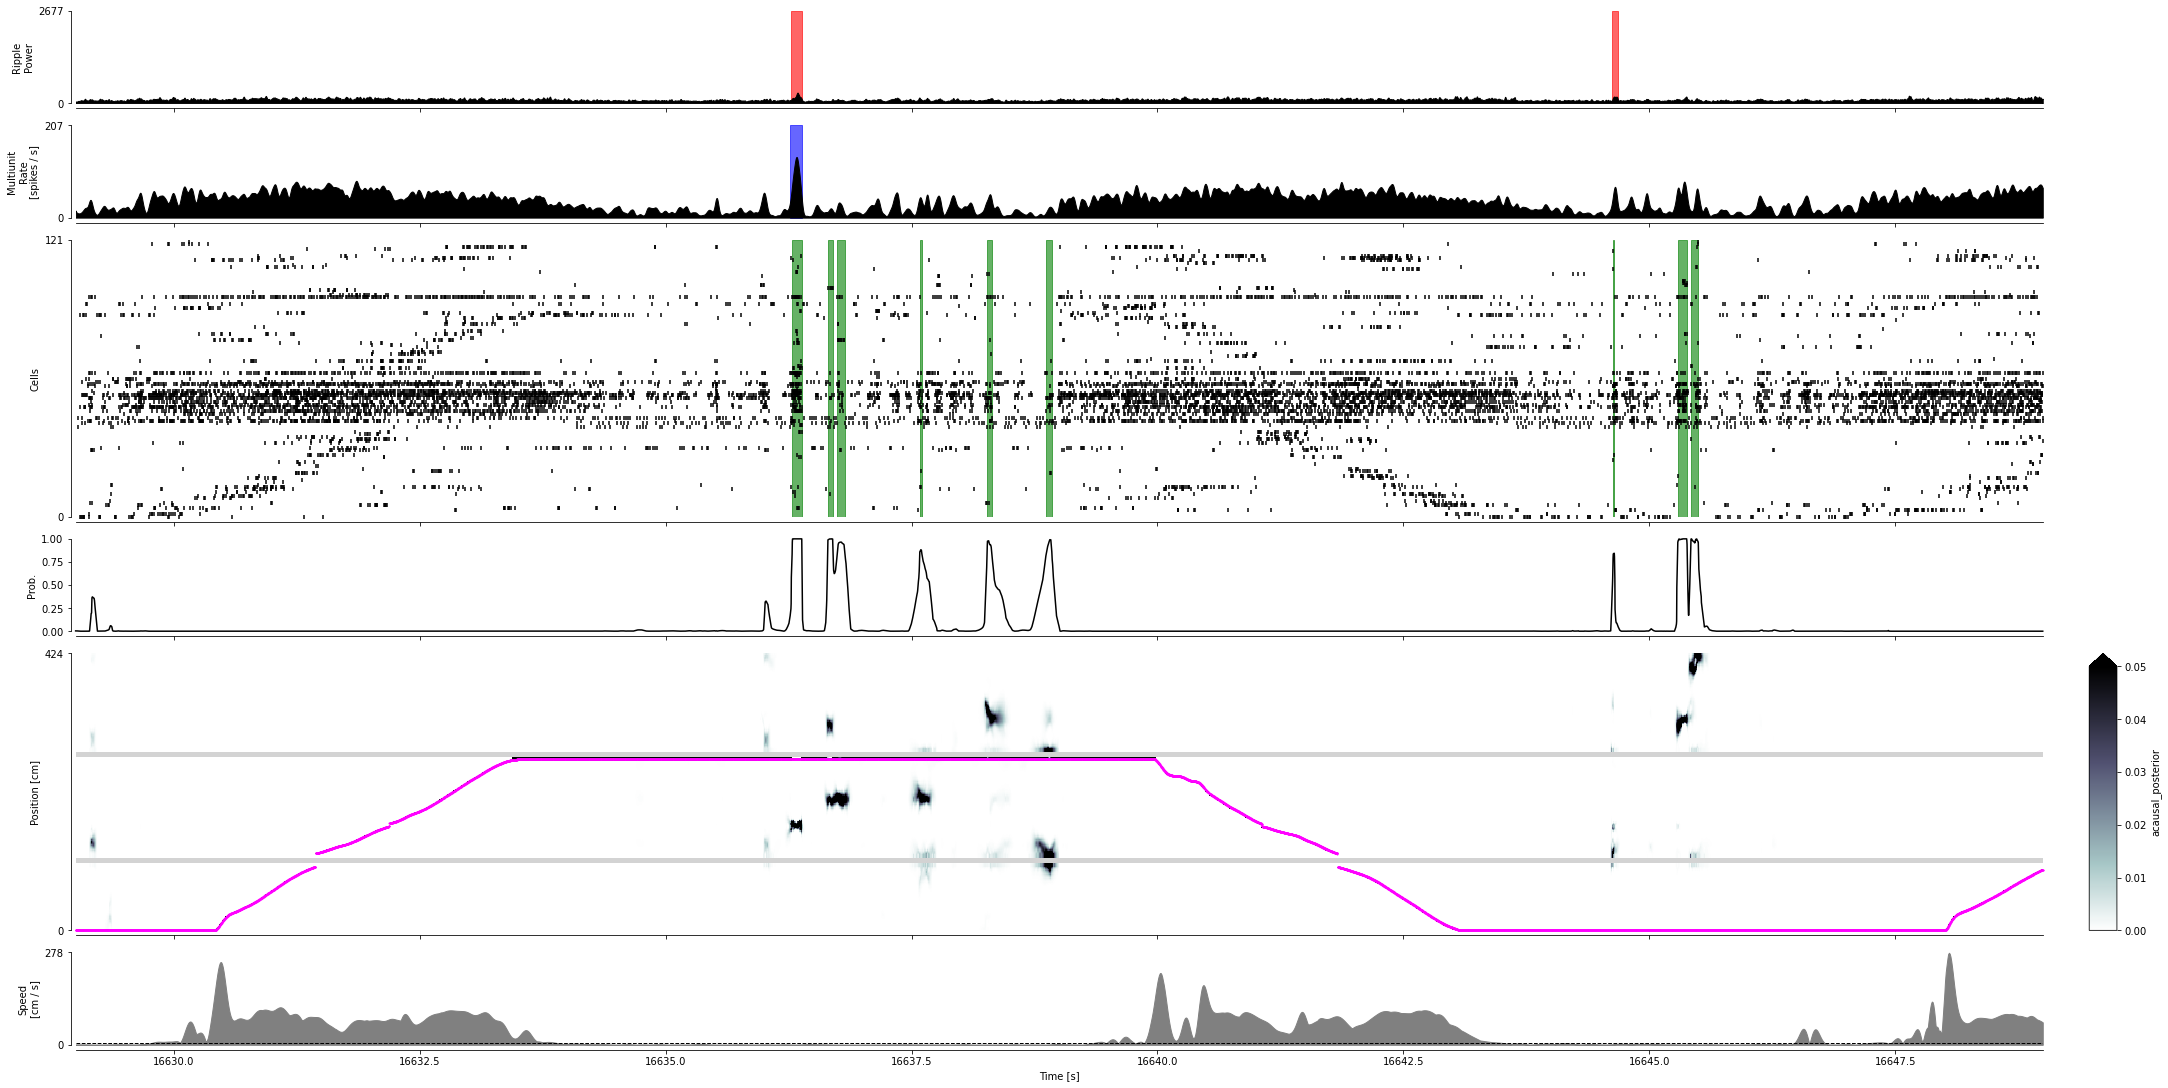

In [18]:
time_ind = slice(130_000, 140_000)

plot_detector(time_ind, data, replay_detector, detector_results, figsize=(30, 15))

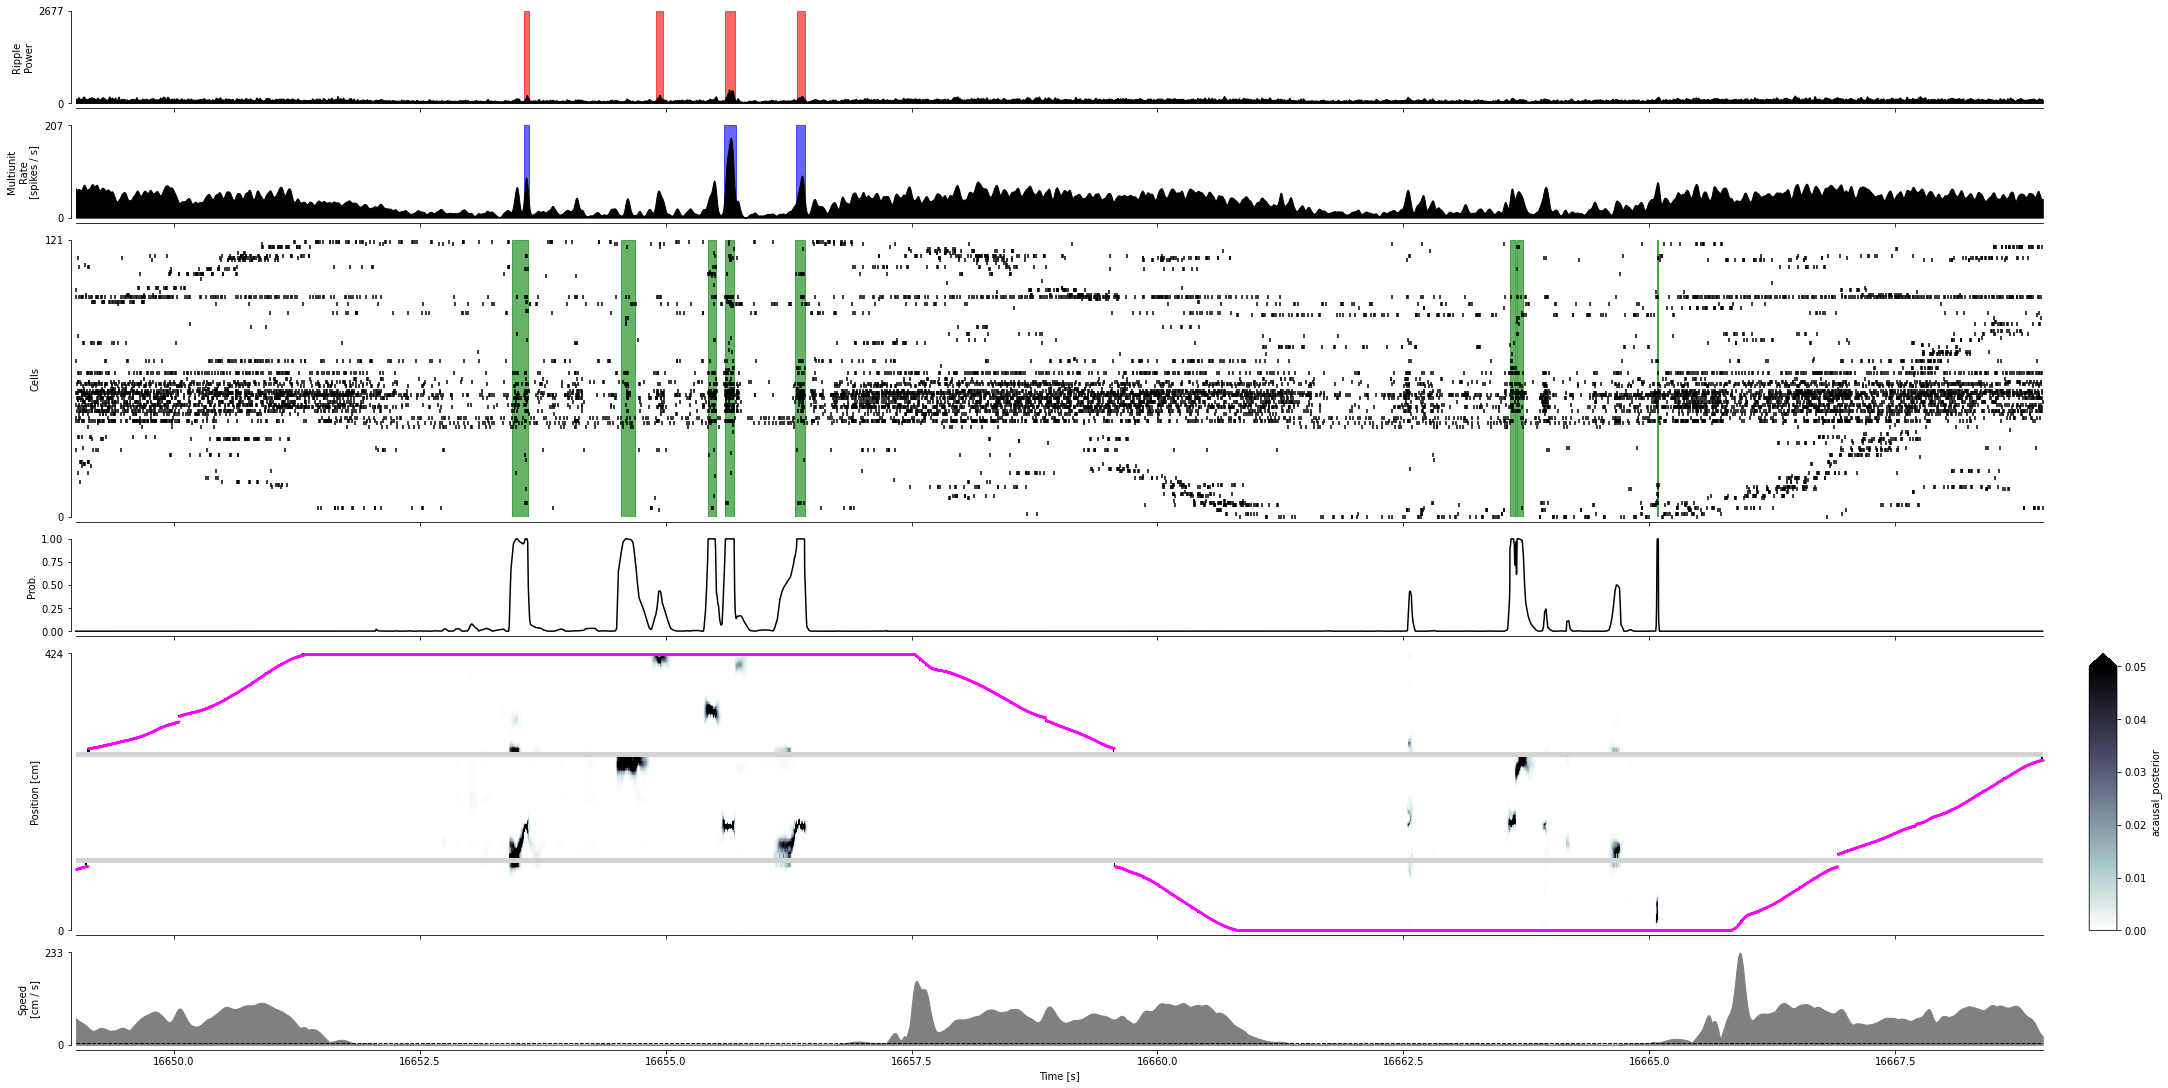

In [19]:
time_ind = slice(140_000, 150_000)

plot_detector(time_ind, data, replay_detector, detector_results, figsize=(30, 15))

In [20]:
time_inds = np.stack((np.arange(0, detector_results.time.shape[0], 10_000),
                      np.append(np.arange(10_000, detector_results.time.shape[0], 10_000), detector_results.time.shape[0]-1)
                     ), axis=1)
for ind, (start, end) in enumerate(time_inds):
    time_ind = slice(start, end)
    print(time_ind)
    plot_detector(time_ind, data, replay_detector, detector_results)
    plt.suptitle(f"time: {detector_results.time.values[start]:0.3f} s - {detector_results.time.values[end]:0.3f} s")
    fig_name = f"time_chunks/time_chunk_{ind:02d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

slice(0, 10000, None)
slice(10000, 20000, None)
slice(20000, 30000, None)
slice(30000, 40000, None)
slice(40000, 50000, None)
slice(50000, 60000, None)
slice(60000, 70000, None)
slice(70000, 80000, None)
slice(80000, 90000, None)
slice(90000, 100000, None)
slice(100000, 110000, None)
slice(110000, 120000, None)
slice(120000, 130000, None)
slice(130000, 140000, None)
slice(140000, 150000, None)
slice(150000, 160000, None)
slice(160000, 170000, None)
slice(170000, 180000, None)
slice(180000, 190000, None)
slice(190000, 200000, None)
slice(200000, 210000, None)
slice(210000, 220000, None)
slice(220000, 230000, None)
slice(230000, 240000, None)
slice(240000, 250000, None)
slice(250000, 260000, None)
slice(260000, 270000, None)
slice(270000, 280000, None)
slice(280000, 290000, None)
slice(290000, 300000, None)
slice(300000, 310000, None)
slice(310000, 320000, None)
slice(320000, 330000, None)
slice(330000, 340000, None)
slice(340000, 350000, None)
slice(350000, 360000, None)
slice(360000, 3

In [21]:
from scipy.ndimage.measurements import label
import pandas as pd

def start_time(s):
    return s.index[0]


def end_time(s):
    return s.index[-1]


def max_probability(df):
    return df.max()


def duration(df):
    return (df.index[-1] - df.index[0])


def get_replay_times(results, probability_threshold=0.8,
                     minimum_duration=0.000):

    replay_labels = label(
        results.replay_probability > probability_threshold)[0]
    labels = pd.DataFrame(
        {'replay_number': replay_labels,
         'replay_probability': results.replay_probability.values},
        index=results.time.to_index())

    grouper = labels.loc[labels.replay_number > 0].groupby('replay_number')
    replay_times = (grouper
                    .agg([start_time, end_time, duration, max_probability]))
    replay_times.columns = replay_times.columns.get_level_values(1)

    replay_times = replay_times.loc[replay_times.duration > minimum_duration]
    labels[~labels.isin(replay_times.index.values)] = 0

    return replay_times, labels


In [22]:
replay_info, is_replay = get_replay_times(detector_results)
replay_info

,start_time,end_time,duration,max_probability
replay_number,,,,
1,16375.099892,16376.003892,0.904,1.000000
2,16376.217892,16376.253892,0.036,1.000000
3,16376.361892,16376.399892,0.038,0.999962
4,16377.351892,16377.449892,0.098,0.908747
5,16377.827892,16377.941892,0.114,0.997879
...,...,...,...,...
507,17260.669892,17260.927892,0.258,1.000000
508,17261.169892,17261.211892,0.042,0.931203
509,17263.073892,17263.107892,0.034,0.999992


In [23]:
time_index = np.arange(detector_results.time.size)

for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    start_ind -= 125
    start_ind = max(0, start_ind)
    end_ind += 125
    end_ind = min(time_index.max(), end_ind)
    time_ind = slice(start_ind, end_ind)
    print(replay_number)
    figsize = (20 * (end_ind - start_ind) / 1000, 7.5)
    plot_detector(time_ind, data, replay_detector, detector_results, figsize=figsize)
    plt.suptitle(f"Replay Number: {replay_number}")
    fig_name = f"replays/replay_number_{replay_number:03d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


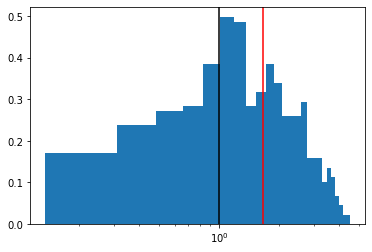

In [24]:
avg_multiunit_rate = []
for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    time_ind = slice(start_ind, end_ind)
    avg_multiunit_rate.append(data['multiunit_firing_rate'].iloc[time_ind].mean())
    
avg_multiunit_rate = np.asarray(avg_multiunit_rate)
plt.hist(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean()), color='red')
plt.xscale('log')

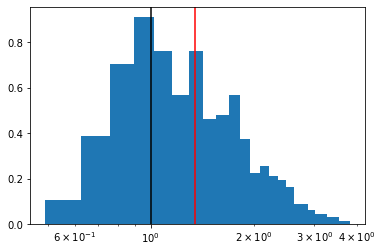

In [25]:
avg_ripple = []
for replay_number in replay_info.itertuples():
    avg_ripple.append(data['ripple_consensus_trace'].set_index(data['ripple_consensus_trace'].index / np.timedelta64(1, 's')).loc[replay_number.start_time:replay_number.end_time].mean())
    
avg_ripple = np.asarray(avg_ripple)
plt.hist(avg_ripple / data['ripple_consensus_trace'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_ripple / data['ripple_consensus_trace'].values.mean()), color='red')
plt.xscale('log')

In [26]:
# from loren_frank_data_processing import make_actual_vs_linearized_position_movie


# make_actual_vs_linearized_position_movie(data['track_graph'], data['position_info'].assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y))

In [27]:
# make_actual_vs_linearized_position_movie(
#     data['track_graph'],
#     (data['position_info']
#      .assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y)
#      .iloc[0:data['position_info'].index.shape[0] + 15:15]
#     ))

In [28]:
client.close()